In [1]:
#http://dacatay.com/data-science/part-6-time-series-prediction-neural-networks-python/

In [2]:
%run 'data_preparation.ipynb'

In [3]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

/home/jawahar/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.

Using TensorFlow backend.


#  Supervised Learning

In [4]:
# set seed
np.random.seed(7)

# prepare the data set
per_day = year.pivot_table(index=['BOOKING_DATE'],values=['BOOKING_HAL_ID'], aggfunc=lambda x: len(x.unique()))
#per_day.reset_index(inplace=True)

data = per_day.values

# using keras often requires the data type float32
data = data.astype('float32')

In [5]:
# slice the data
train = data[:650]
test = data[650:]

In [6]:
def prepare_data(data, lags=1):
    """
    Create lagged data from an input time series
    """
    X, y = [], []
    for row in range(len(data) - lags - 1):
        a = data[row:(row + lags), 0]
        X.append(a)
        b = data[row + lags, 0]
        y.append(b)
    return np.array(X), np.array(y)

In [7]:
lags = 1
X_train, y_train = prepare_data(train, lags)
X_test, y_test = prepare_data(test, lags)
y_true = y_test     # due to naming convention

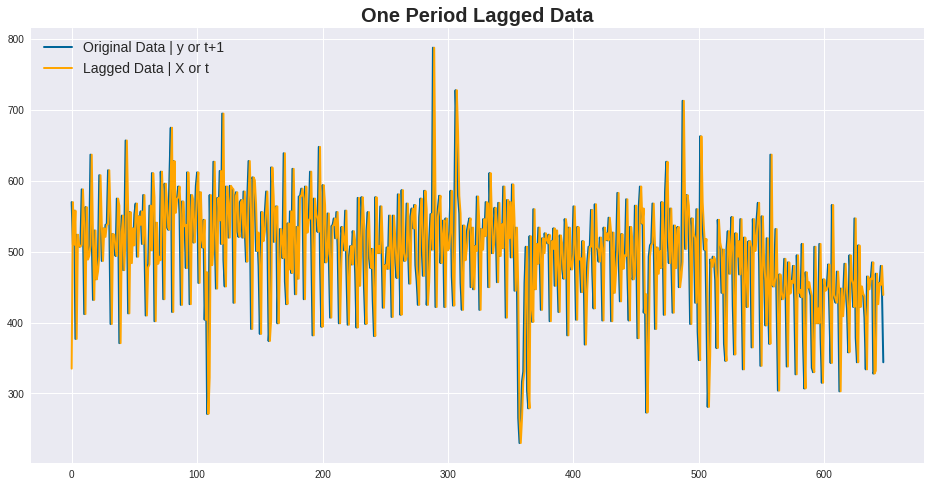

In [8]:
# plot the created data
plt.plot(y_train, label='Original Data | y or t+1', color='#006699')
plt.plot(X_train, label='Lagged Data | X or t', color='orange')
plt.legend(loc='upper left')
plt.title('One Period Lagged Data')
#plt.savefig('./img/ann_training.png')
plt.show()

# Multilayer Perceptron Network

In [9]:
# create and fit Multilayer Perceptron model
mdl = Sequential()
mdl.add(Dense(3, input_dim=lags, activation='relu'))
mdl.add(Dense(1))
mdl.compile(loss='mean_squared_error', optimizer='adam')
mdl.fit(X_train, y_train, epochs=200, batch_size=2, verbose=2)

Epoch 1/200
 - 1s - loss: 91942.9473
Epoch 2/200
 - 0s - loss: 11308.7582
Epoch 3/200
 - 0s - loss: 8166.7771
Epoch 4/200
 - 0s - loss: 8184.2023
Epoch 5/200
 - 0s - loss: 8197.1796
Epoch 6/200
 - 0s - loss: 8171.3282
Epoch 7/200
 - 0s - loss: 8183.3387
Epoch 8/200
 - 0s - loss: 8155.5966
Epoch 9/200
 - 0s - loss: 8168.6568
Epoch 10/200
 - 0s - loss: 8139.1395
Epoch 11/200
 - 0s - loss: 8173.0263
Epoch 12/200
 - 0s - loss: 8192.0437
Epoch 13/200
 - 0s - loss: 8173.9094
Epoch 14/200
 - 0s - loss: 8193.4539
Epoch 15/200
 - 0s - loss: 8163.6984
Epoch 16/200
 - 0s - loss: 8158.5743
Epoch 17/200
 - 0s - loss: 8153.7959
Epoch 18/200
 - 0s - loss: 8219.2195
Epoch 19/200
 - 0s - loss: 8149.6275
Epoch 20/200
 - 0s - loss: 8199.3499
Epoch 21/200
 - 0s - loss: 8175.9823
Epoch 22/200
 - 0s - loss: 8172.0560
Epoch 23/200
 - 0s - loss: 8161.6339
Epoch 24/200
 - 0s - loss: 8146.6272
Epoch 25/200
 - 0s - loss: 8164.1062
Epoch 26/200
 - 0s - loss: 8176.9651
Epoch 27/200
 - 0s - loss: 8163.6843
Epoch 28

In [10]:
# estimate model performance
train_score = mdl.evaluate(X_train, y_train, verbose=0)
print('Train Score: {:.2f} MSE ({:.2f} RMSE)'.format(train_score, math.sqrt(train_score)))
test_score = mdl.evaluate(X_test, y_test, verbose=0)
print('Test Score: {:.2f} MSE ({:.2f} RMSE)'.format(test_score, math.sqrt(test_score)))

Train Score: 7873.23 MSE (88.73 RMSE)
Test Score: 5413.40 MSE (73.58 RMSE)


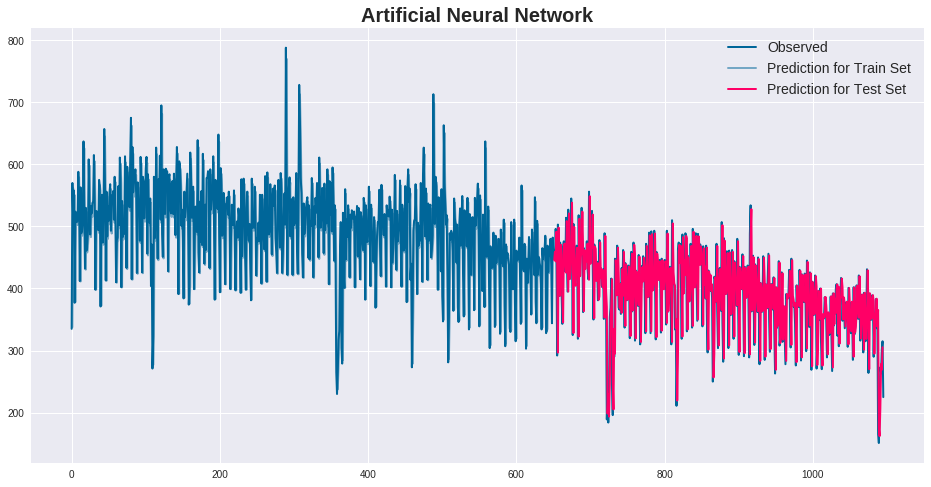

In [11]:
# generate predictions for training
train_predict = mdl.predict(X_train)
test_predict = mdl.predict(X_test)

# shift train predictions for plotting
train_predict_plot = np.empty_like(data)
train_predict_plot[:, :] = np.nan
train_predict_plot[lags: len(train_predict) + lags, :] = train_predict

# shift test predictions for plotting
test_predict_plot = np.empty_like(data)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict)+(lags*2)+1:len(data)-1, :] = test_predict

# plot baseline and predictions
plt.plot(data, label='Observed', color='#006699');
plt.plot(train_predict_plot, label='Prediction for Train Set', color='#006699', alpha=0.5);
plt.plot(test_predict_plot, label='Prediction for Test Set', color='#ff0066');
plt.legend(loc='best');
plt.title('Artificial Neural Network')
#plt.savefig('./img/ann_forecast.png')
plt.show()

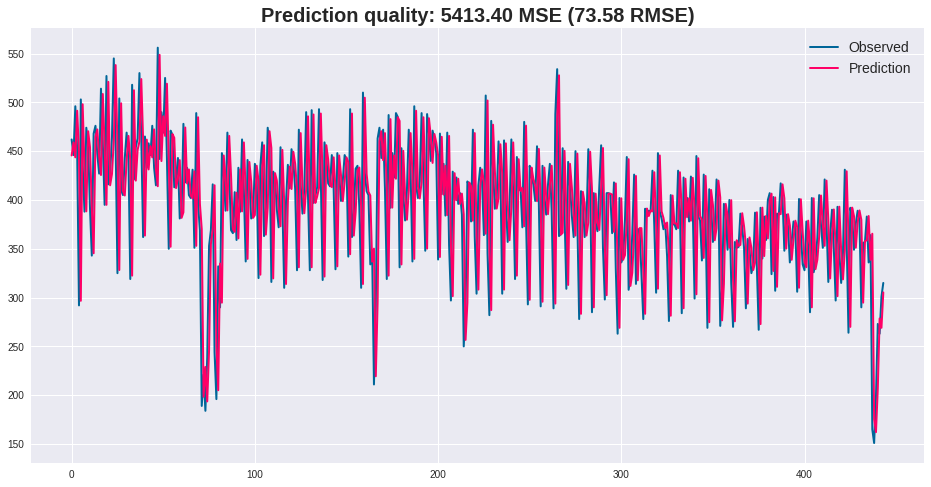

In [12]:
mse = ((y_test.reshape(-1, 1) - test_predict.reshape(-1, 1)) ** 2).mean()
plt.title('Prediction quality: {:.2f} MSE ({:.2f} RMSE)'.format(mse, math.sqrt(mse)))
plt.plot(y_test.reshape(-1, 1), label='Observed', color='#006699')
plt.plot(test_predict.reshape(-1, 1), label='Prediction', color='#ff0066')
plt.legend(loc='best');
#plt.savefig('./img/ann_close.png')
plt.show()

# Multilayer perceptron with window

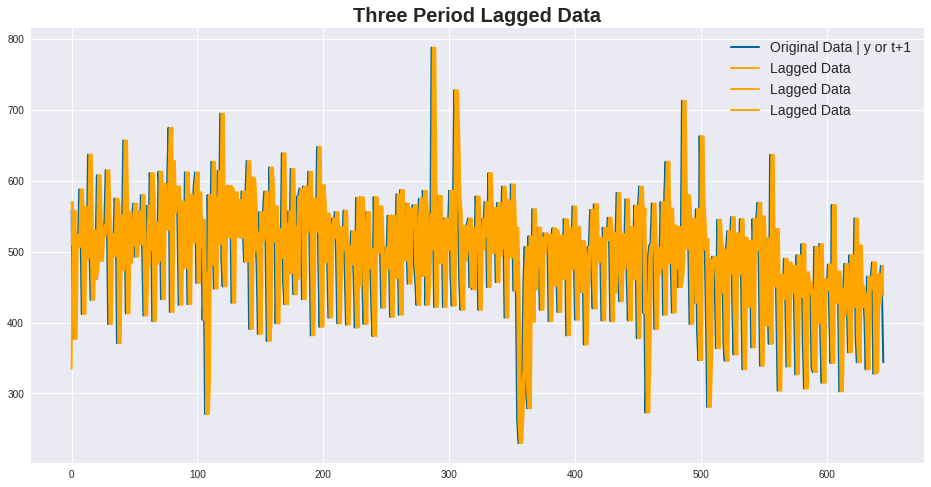

In [13]:
# reshape and lag shift the dataset
lags = 3
X_train, y_train = prepare_data(train, lags)
X_test, y_test = prepare_data(test, lags)

# plot the created data
plt.plot(y_train, label='Original Data | y or t+1', color='#006699')
plt.plot(X_train, label='Lagged Data', color='orange')
plt.legend(loc='best')
plt.title('Three Period Lagged Data')
#plt.savefig('./img/ann3_training.png')
plt.show()


In [14]:
# create and fit Multilayer Perceptron model
mdl = Sequential()
mdl.add(Dense(4, input_dim=lags, activation='relu'))
mdl.add(Dense(8, activation='relu'))
mdl.add(Dense(1))
mdl.compile(loss='mean_squared_error', optimizer='adam')
mdl.fit(X_train, y_train, epochs=400, batch_size=2, verbose=2)

Epoch 1/400
 - 0s - loss: 55540.3558
Epoch 2/400
 - 0s - loss: 6831.5726
Epoch 3/400
 - 0s - loss: 6862.4095
Epoch 4/400
 - 0s - loss: 6747.3360
Epoch 5/400
 - 0s - loss: 6683.6082
Epoch 6/400
 - 0s - loss: 6598.0836
Epoch 7/400
 - 0s - loss: 6578.1435
Epoch 8/400
 - 0s - loss: 6480.7009
Epoch 9/400
 - 0s - loss: 6435.9189
Epoch 10/400
 - 0s - loss: 6370.7540
Epoch 11/400
 - 0s - loss: 6325.2984
Epoch 12/400
 - 0s - loss: 6212.9242
Epoch 13/400
 - 0s - loss: 6261.5611
Epoch 14/400
 - 0s - loss: 6200.4007
Epoch 15/400
 - 0s - loss: 6137.1312
Epoch 16/400
 - 0s - loss: 6078.1628
Epoch 17/400
 - 0s - loss: 6010.8956
Epoch 18/400
 - 0s - loss: 6053.7869
Epoch 19/400
 - 0s - loss: 6017.0245
Epoch 20/400
 - 0s - loss: 5993.3721
Epoch 21/400
 - 0s - loss: 5955.8661
Epoch 22/400
 - 0s - loss: 5938.0416
Epoch 23/400
 - 0s - loss: 5830.0161
Epoch 24/400
 - 0s - loss: 5844.9966
Epoch 25/400
 - 0s - loss: 5862.0502
Epoch 26/400
 - 0s - loss: 5914.4082
Epoch 27/400
 - 0s - loss: 5846.8176
Epoch 28/

Epoch 220/400
 - 0s - loss: 5064.7177
Epoch 221/400
 - 0s - loss: 5046.5147
Epoch 222/400
 - 0s - loss: 5068.3798
Epoch 223/400
 - 0s - loss: 5052.7083
Epoch 224/400
 - 0s - loss: 5052.5950
Epoch 225/400
 - 0s - loss: 5078.4915
Epoch 226/400
 - 0s - loss: 5085.0990
Epoch 227/400
 - 0s - loss: 5037.1129
Epoch 228/400
 - 0s - loss: 5057.8422
Epoch 229/400
 - 0s - loss: 5050.4749
Epoch 230/400
 - 0s - loss: 5055.2312
Epoch 231/400
 - 0s - loss: 5098.8554
Epoch 232/400
 - 0s - loss: 5087.8824
Epoch 233/400
 - 0s - loss: 5053.4244
Epoch 234/400
 - 0s - loss: 5130.0625
Epoch 235/400
 - 0s - loss: 5052.1860
Epoch 236/400
 - 0s - loss: 5038.2498
Epoch 237/400
 - 0s - loss: 5065.1214
Epoch 238/400
 - 0s - loss: 5047.8944
Epoch 239/400
 - 0s - loss: 5099.0655
Epoch 240/400
 - 0s - loss: 4976.1090
Epoch 241/400
 - 0s - loss: 5009.2074
Epoch 242/400
 - 0s - loss: 4996.3102
Epoch 243/400
 - 0s - loss: 5043.8421
Epoch 244/400
 - 0s - loss: 5037.4781
Epoch 245/400
 - 0s - loss: 5037.5322
Epoch 246/40

In [15]:
# Estimate model performance
train_score = mdl.evaluate(X_train, y_train, verbose=0)
print('Train Score: {:.2f} MSE ({:.2f} RMSE)'.format(train_score, math.sqrt(train_score)))
test_score = mdl.evaluate(X_test, y_test, verbose=0)
print('Test Score: {:.2f} MSE ({:.2f} RMSE)'.format(test_score, math.sqrt(test_score)))

Train Score: 4912.00 MSE (70.09 RMSE)
Test Score: 3156.05 MSE (56.18 RMSE)


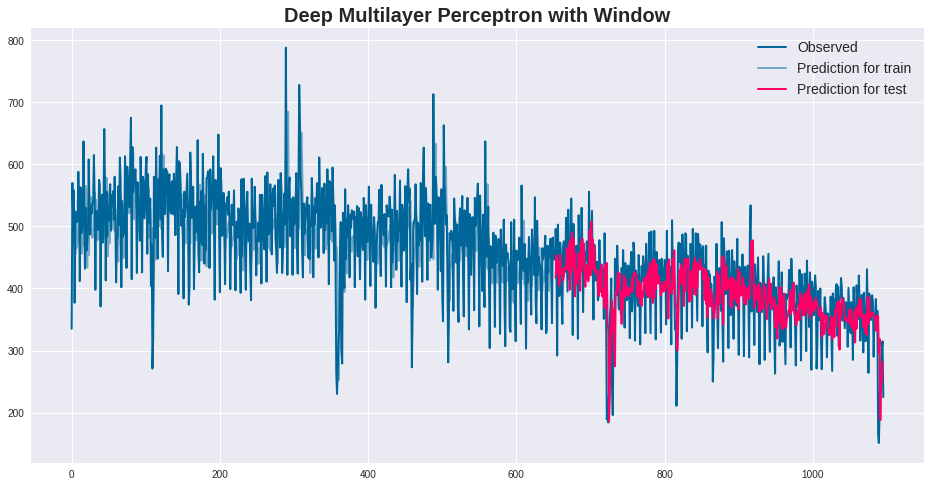

In [16]:
# generate predictions for training
train_predict = mdl.predict(X_train)
test_predict = mdl.predict(X_test)

# shift train predictions for plotting
train_predict_plot = np.empty_like(data)
train_predict_plot[:, :] = np.nan
train_predict_plot[lags: len(train_predict) + lags, :] = train_predict

# shift test predictions for plotting
test_predict_plot = np.empty_like(data)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict)+(lags * 2)+1:len(data)-1, :] = test_predict

# plot observation and predictions
plt.plot(data, label='Observed', color='#006699');
plt.plot(train_predict_plot, label='Prediction for train', color='#006699', alpha=0.5);
plt.plot(test_predict_plot, label='Prediction for test', color='#ff0066');
plt.legend(loc='best')
plt.title('Deep Multilayer Perceptron with Window')
#plt.savefig('./img/ann3_forecast.png')
plt.show()

In [17]:
y_test

array([496., 452., 292., 503., 436., 388., 474., 457., 392., 343., 468.,
       476., 447., 427., 514., 458., 395., 527., 416., 428., 464., 545.,
       458., 325., 504., 410., 405., 443., 469., 443., 319., 518., 421.,
       454., 463., 530., 465., 362., 465., 433., 458., 446., 476., 433.,
       415., 556., 442., 490., 469., 525., 443., 350., 471., 467., 413.,
       423., 443., 381., 387., 478., 418., 433., 405., 402., 431., 351.,
       489., 396., 369., 189., 221., 184., 239., 353., 369., 416., 244.,
       196., 332., 290., 448., 424., 389., 469., 426., 369., 366., 408.,
       359., 433., 388., 462., 409., 337., 441., 420., 381., 384., 437.,
       421., 320., 435., 459., 363., 392., 474., 456., 316., 429., 421.,
       390., 372., 454., 398., 310., 398., 436., 412., 452., 439., 411.,
       328., 472., 415., 386., 412., 490., 404., 328., 492., 397., 404.,
       413., 493., 421., 318., 459., 444., 417., 414., 446., 412., 329.,
       448., 427., 399., 420., 446., 441., 342., 49

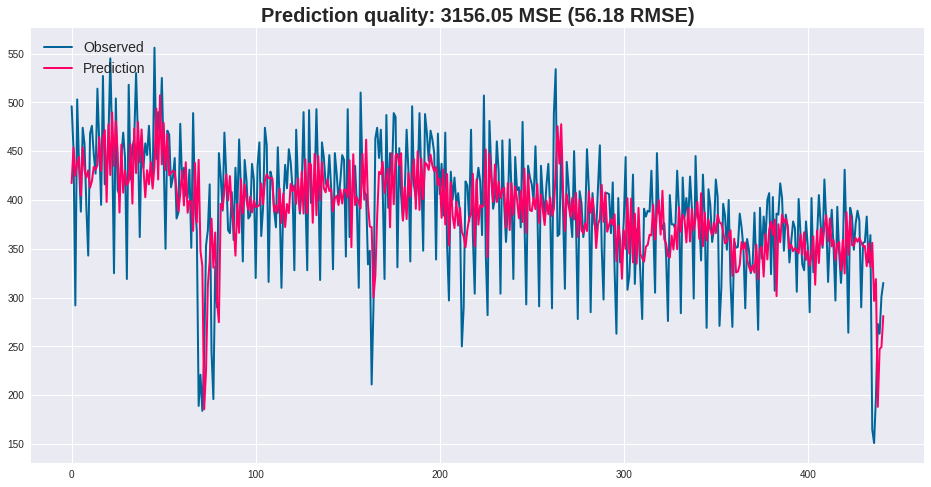

In [18]:
mse = ((y_test.reshape(-1, 1) - test_predict.reshape(-1, 1)) ** 2).mean()
plt.title('Prediction quality: {:.2f} MSE ({:.2f} RMSE)'.format(mse, math.sqrt(mse)))
plt.plot(y_test.reshape(-1, 1), label='Observed', color='#006699')
plt.plot(test_predict.reshape(-1, 1), label='Prediction', color='#ff0066')
plt.legend(loc='upper left');
#plt.savefig('./img/ann3_close.png')
plt.show()

# LSTM Recurrent Neural Network

In [19]:
# fix random seed for reproducibility
np.random.seed(1)

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(data)

# split into train and test sets
train = dataset[0:520, :]
test = dataset[520:, :]

# reshape into X=t and Y=t+1
lags = 3
X_train, y_train = prepare_data(train, lags)
X_test, y_test = prepare_data(test, lags)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [20]:
# create and fit the LSTM network
mdl = Sequential()
mdl.add(Dense(3, input_shape=(1, lags), activation='relu'))
mdl.add(LSTM(6, activation='relu'))
mdl.add(Dense(1, activation='relu'))
mdl.compile(loss='mean_squared_error', optimizer='adam')
mdl.fit(X_train, y_train, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
 - 2s - loss: 0.0416
Epoch 2/100
 - 1s - loss: 0.0139
Epoch 3/100
 - 1s - loss: 0.0125
Epoch 4/100
 - 1s - loss: 0.0124
Epoch 5/100
 - 1s - loss: 0.0120
Epoch 6/100
 - 1s - loss: 0.0122
Epoch 7/100
 - 1s - loss: 0.0120
Epoch 8/100
 - 1s - loss: 0.0119
Epoch 9/100
 - 2s - loss: 0.0118
Epoch 10/100
 - 1s - loss: 0.0119
Epoch 11/100
 - 1s - loss: 0.0116
Epoch 12/100
 - 1s - loss: 0.0121
Epoch 13/100
 - 1s - loss: 0.0119
Epoch 14/100
 - 1s - loss: 0.0117
Epoch 15/100
 - 1s - loss: 0.0120
Epoch 16/100
 - 1s - loss: 0.0118
Epoch 17/100
 - 1s - loss: 0.0118
Epoch 18/100
 - 1s - loss: 0.0118
Epoch 19/100
 - 1s - loss: 0.0119
Epoch 20/100
 - 1s - loss: 0.0119
Epoch 21/100
 - 1s - loss: 0.0118
Epoch 22/100
 - 2s - loss: 0.0115
Epoch 23/100
 - 1s - loss: 0.0117
Epoch 24/100
 - 1s - loss: 0.0119
Epoch 25/100
 - 2s - loss: 0.0116
Epoch 26/100
 - 1s - loss: 0.0116
Epoch 27/100
 - 1s - loss: 0.0118
Epoch 28/100
 - 1s - loss: 0.0117
Epoch 29/100
 - 1s - loss: 0.0118
Epoch 30/100
 - 1s - lo

In [21]:
# make predictions
train_predict = mdl.predict(X_train)
test_predict = mdl.predict(X_test)

# invert transformation
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

In [22]:
# calculate root mean squared error
train_score = math.sqrt(mean_squared_error(y_train[0], train_predict[:,0]))
print('Train Score: {:.2f} RMSE'.format(train_score))
test_score = math.sqrt(mean_squared_error(y_test[0], test_predict[:,0]))
print('Test Score: {:.2f} RMSE'.format(test_score))

Train Score: 68.37 RMSE
Test Score: 104.67 RMSE


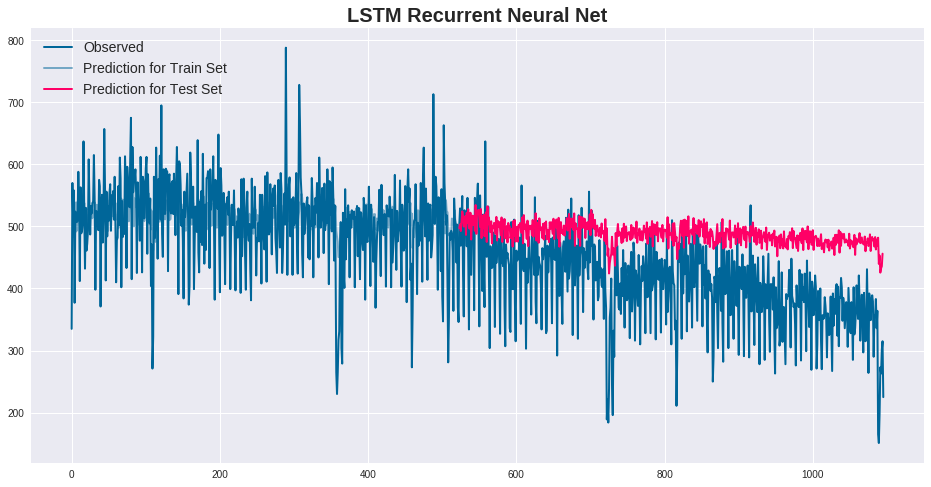

In [23]:
# shift train predictions for plotting
train_predict_plot = np.empty_like(data)
train_predict_plot[:, :] = np.nan
train_predict_plot[lags:len(train_predict)+lags, :] = train_predict

# shift test predictions for plotting
test_predict_plot = np.empty_like(data)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + (lags * 2)+1:len(data)-1, :] = test_predict

# plot observation and predictions
plt.plot(data, label='Observed', color='#006699');
plt.plot(train_predict_plot, label='Prediction for Train Set', color='#006699', alpha=0.5);
plt.plot(test_predict_plot, label='Prediction for Test Set', color='#ff0066');
plt.legend(loc='upper left')
plt.title('LSTM Recurrent Neural Net')
#plt.savefig('./img/lstm_forecast.png')
plt.show()

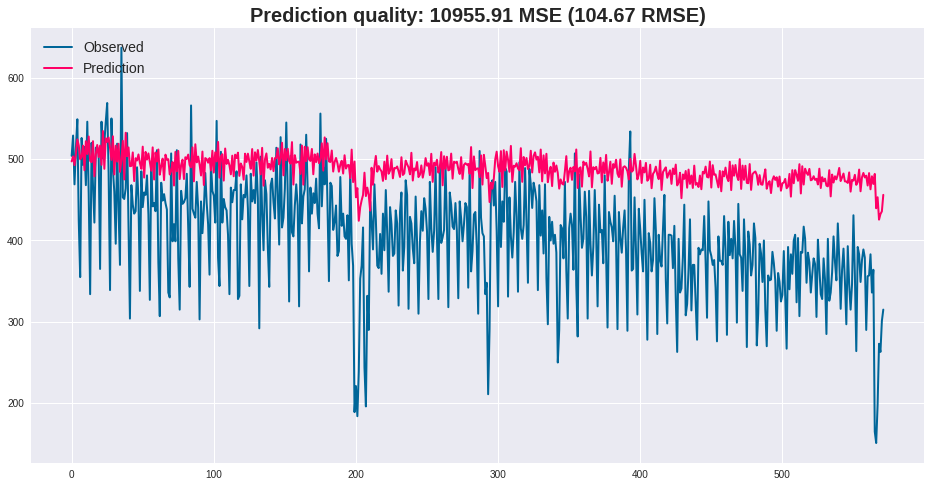

In [24]:
mse = ((y_test.reshape(-1, 1) - test_predict.reshape(-1, 1)) ** 2).mean()
plt.title('Prediction quality: {:.2f} MSE ({:.2f} RMSE)'.format(mse, math.sqrt(mse)))
plt.plot(y_test.reshape(-1, 1), label='Observed', color='#006699')
plt.plot(test_predict.reshape(-1, 1), label='Prediction', color='#ff0066')
plt.legend(loc='upper left');
#plt.savefig('./img/lstm_close.png')
plt.show()

# Observations